In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import datetime
from astropy import units as u
import scopesim as sim
import scopesim_templates as sim_tp
import astropy.units as u
from scopesim.effects.ter_curves import FilterCurve

In [2]:
src = sim_tp.stellar.clusters.cluster(mass=10000, distance=2000, core_radius=5.0)

imf - sample_imf: Setting maximum allowed mass to 10000
imf - sample_imf: Loop 0 added 1.01e+04 Msun to previous total of 0.00e+00 Msun


In [3]:
cmd = sim.UserCommands(
    use_instrument="MICADO",
    set_modes=["IMG_4mas", "SCAO"],
)
cmd.update(properties={
    "!OBS.filter_name": "J_DREAMS",
    "!OBS.ndit": 1, 
    "!OBS.dit": 3600,

    "!OBS.catg": "SCIENCE",
    "!OBS.tech": "IMAGE",
    "!OBS.type": "OBJECT",
    "!OBS.mjdobs": datetime.datetime(2022, 1, 1, 2, 30, 0),

    "!DET.bin_size": 1,

    # "!INST.filter_file_format": "filters/{}.dat",
})
micado = sim.OpticalTrain(cmd)
    

In [4]:
pixel_scale_micado, plate_scale_micado, pixel_size_micado = 0.004, 0.26666666666, 0.015
pixel_size_micado * plate_scale_micado / pixel_scale_micado

0.999999999975

In [5]:
pixel_scale_dreams, plate_scale_dreams, pixel_size_dreams = 2.48, 206.265, 0.012
pixel_size_dreams * plate_scale_dreams / pixel_scale_dreams

0.9980564516129032

In [6]:
pixel_scale = micado.cmds["!INST.pixel_scale"]
plate_scale = micado.cmds["!INST.plate_scale"]
pixel_size = micado['full_detector_array'].data["pixel_size"][0]
pixel_size, plate_scale, pixel_scale, pixel_size * plate_scale / pixel_scale

(0.012, 206.265, 2.48, 0.9980564516129032)

In [7]:
micado.observe(src)
hdus = micado.readout()

 FOVs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]
 Image Plane effects: 0it [00:00, ?it/s]

astar.scopesim.detector.detector_array - Extracting from 6 detectors...


astar.scopesim.optics.optical_train - ERROR: Header update failed, data will be saved with incomplete header. See stack trace for details.
Traceback (most recent call last):
  File "/mnt/bulk/hugo/repos/scopesim/ScopeSim/scopesim/optics/optical_train.py", line 386, in readout
    hdul = self.write_header(hdul)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/bulk/hugo/repos/scopesim/ScopeSim/scopesim/optics/optical_train.py", line 410, in write_header
    pheader["TELESCOP"] = from_currsys("!TEL.telescope", self.cmds)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/bulk/hugo/repos/scopesim/ScopeSim/scopesim/utils.py", line 542, in from_currsys
    raise ValueError(f"{item} was not found in rc.__currsys__")
ValueError: !TEL.telescope was not found in rc.__currsys__


In [8]:
filter_J_MICADO = FilterCurve(filename="filters/TC_filter_J.dat")
filter_J_DREAMS = FilterCurve(filename="filters/TC_filter_J_DREAMS.dat")

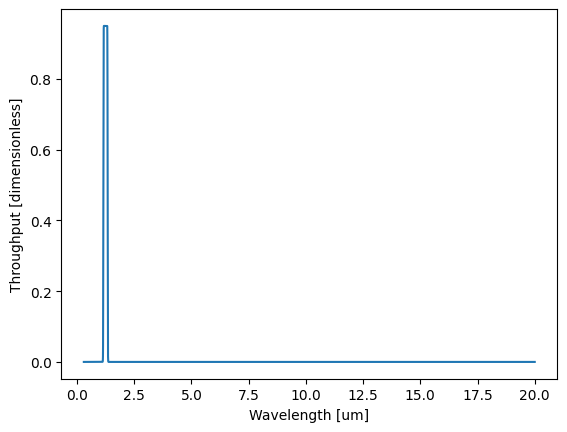

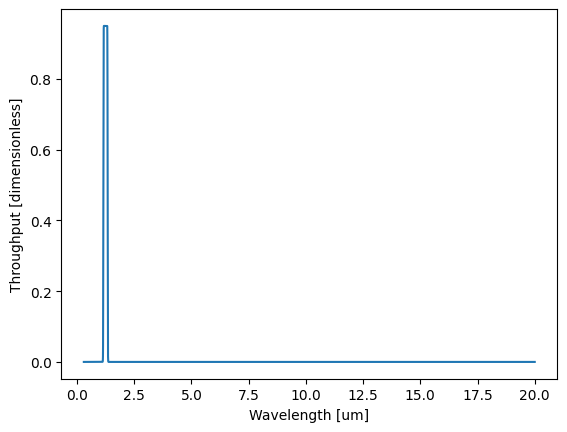

In [9]:
filter_J_MICADO.plot()

astar.scopesim.effects.ter_curves - WARNING: wavelength units in the meta dict of {'untitled filter'} are inconsistent:
- wavelength_unit : angstrom
- wave_unit : um


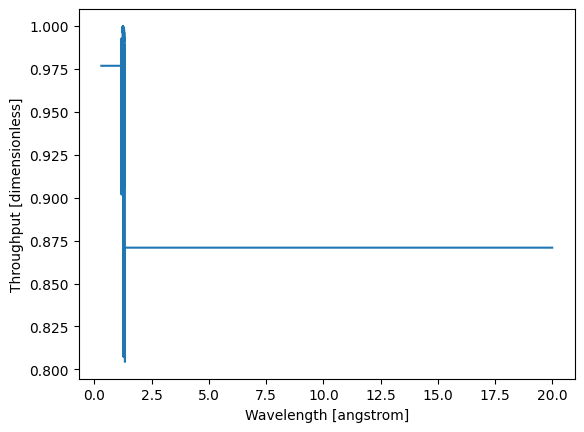

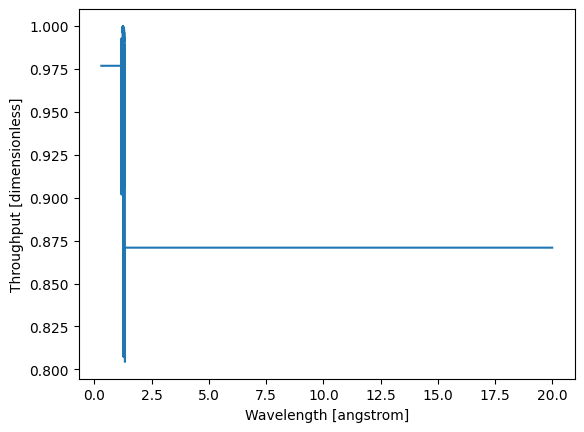

In [10]:
filter_J_DREAMS.plot()

In [11]:
len(hdus[0])

7

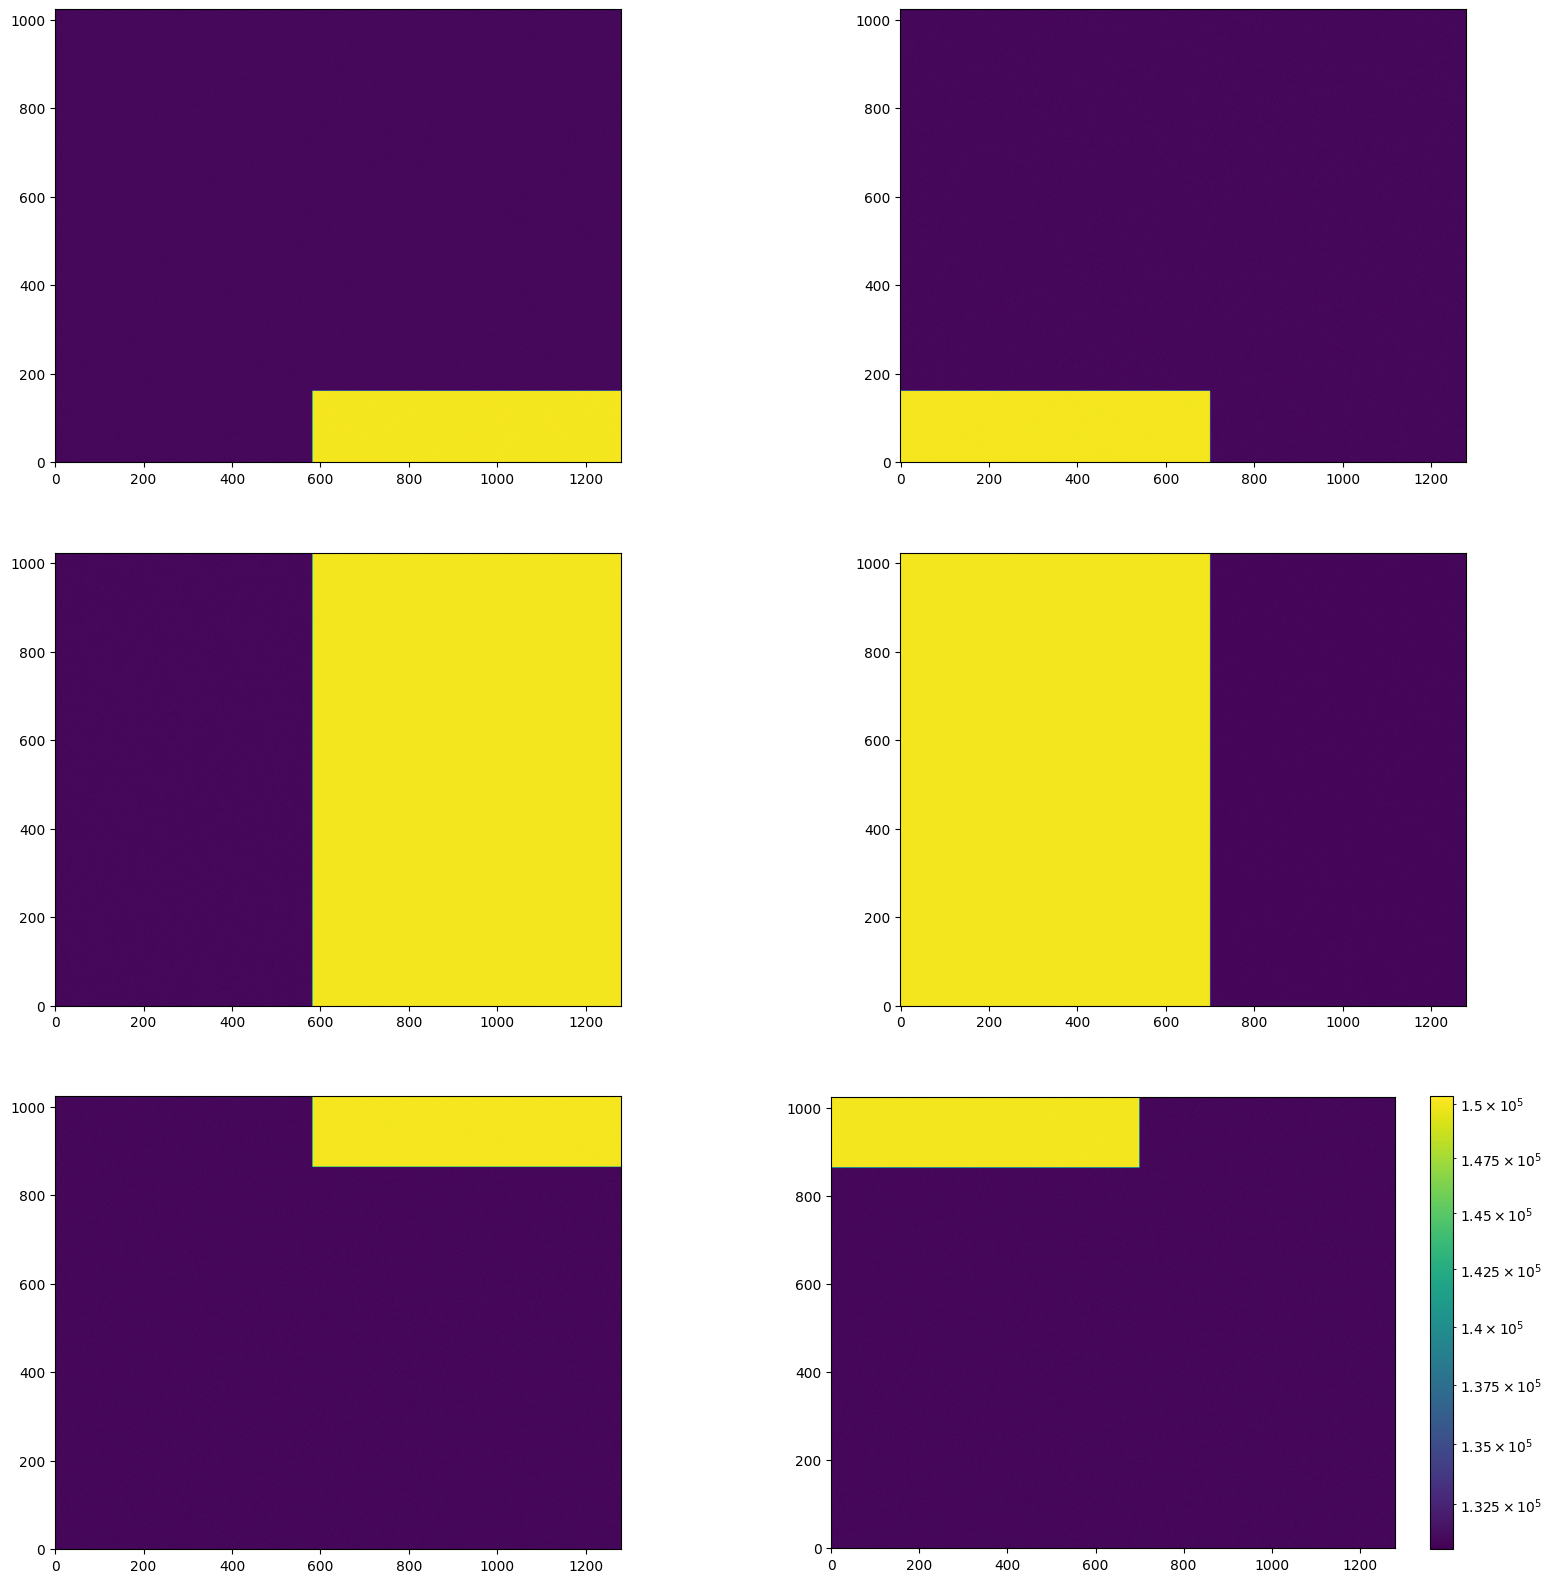

In [12]:
detector_order = [2, 1, 4, 3, 6, 5]
# detector_order = [1, 1, 1, 1, 1 ,1]  # To test with 1 detector
plt.figure(figsize=(20, 20))
for plot_number, hdu_number in enumerate(detector_order, 1):
    plt.subplot(3, 2, plot_number)

    plt.imshow(hdus[0][hdu_number].data, origin="lower", norm=LogNorm())

plt.colorbar()
plt.savefig("MICADO_with_DREAMS_detector_array.png")

In [13]:
# pixel_size = 0.012 * u.mm / u.pixel
a_pixel_size = pixel_size * u.mm / u.pixel
a_pixel_scale = pixel_scale * u.arcsec / u.pixel
a_plate_scale = plate_scale * u.arcsec / u.mm

x_left = 400 * u.pixel
x_right = 880 * u.pixel
y_bottom = 680 * u.pixel
y_top = 250 * u.pixel
x_size = 1280 * u.pixel
y_size = 1024 * u.pixel
x_width = x_size * a_pixel_size
y_height = y_size * a_pixel_size
x_diff = 8.015 * u.mm - -8.015 * u.mm
y_diff = 12.95 * u.mm

x_gap = x_diff - x_width
y_gap = y_diff - y_height
print(x_width, y_height, x_gap, y_gap)
print( (((x_size - x_left) + (x_right)) * a_pixel_size + x_gap) * a_plate_scale)
print( (((y_size - y_bottom) + y_size + (y_top)) * a_pixel_size + 2 * y_gap) * a_plate_scale)

15.36 mm 12.288 mm 0.6700000000000017 mm 0.661999999999999 mm
4494.51435 arcsec
4277.936099999999 arcsec


In [14]:
pixel_size

0.012

In [15]:
hdus[0][0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2024-07-03T17:15:42'                                                 
ORIGIN  = 'Scopesim 0.8.2'                                                      
INSTRUME= 'MICADO  '                                                            
INSTMODE= 'IMG_4mas, SCAO'                                                      

In [16]:
hdus[0].writeto("my_dithered_cluster.fits", overwrite=True)